In [281]:
import gc
import pathlib

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

In [282]:
%run ../wmis_gnn_py/util/metis.py
%run ../wmis_gnn_py/util/gurobi_wmis.py
%run ../wmis_gnn_py/util/subgraph.py
%run ../wmis_gnn_py/util/greedy.py
%run ../wmis_gnn_py/util/pyg_interface.py

# Small Erdos-Reyni Graphs

In [212]:
er_paths = list(yield_metis_filenames("../data/erdos_reyni_small/"))
er_labels = list(yield_solution_filenames("../data/erdos_reyni_small/label"))
pace_paths = list(yield_metis_filenames("../data/pace_weighted/"))

In [213]:
G = metis_to_nx(er_paths[0])

In [143]:
G_prime = G.copy()
solution_to_nx(G_prime, er_labels[0])
assert is_independent(G_prime)

opt_weight = sum(
    G_prime.nodes[v]["weight"]
    for v in G_prime.nodes
    if G_prime.nodes[v]["solution"] == 1.0
)
opt_weight

9554

In [144]:
wmis_lp(G)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads
Optimize a model with 2013 rows, 200 columns and 4026 nonzeros
Model fingerprint: 0x2efff399
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 2013 rows, 200 columns, 4026 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4125662e+04   1.528150e+03   0.000000e+00      0s
     172    1.8774500e+04   0.000000e+00   0.000000e+00      0s

Solved in 172 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.877450000e+04


In [145]:
H = get_unsolved_view(G)

In [146]:
greedy_wmis(H)
assert is_independent(G)

In [147]:
sum(G.nodes[v]["weight"] for v in G.nodes if G.nodes[v]["solution"] == 1.0) / opt_weight

0.6102156164957087

# PyG

In [412]:
import torch
import torch_geometric as pyg
from torch.nn import functional as F

In [413]:
torch.cuda.is_available()

True

In [414]:
dataset = WMISDataset("../data/erdos_reyni_small/").shuffle()
# dataset = torch.load("test.pt")
print(len(dataset))

loader_train = pyg.loader.DataLoader(dataset[:800], batch_size=64, shuffle=True)
loader_train_eval = pyg.loader.DataLoader(dataset[:800], batch_size=1, shuffle=True)
loader_eval = pyg.loader.DataLoader(dataset[800:1000], batch_size=1, shuffle=True)

1000


In [415]:
dataset[0]

Data(edge_index=[2, 3916], weight=[200], solution=[200], id=[200], x=[200, 3])

## MLP

In [416]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # TODO: Define two Linear modules and a ReLU function.
        # The input size and output size of first Linear module should be input_dim and hidden_dim
        # The input size and output size of second Linear module should be hidden_dim and output_dim

        ############# Your code here ############
        ## (~3 line of code)
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels

        self.sequential = torch.nn.Sequential(
            pyg.nn.Linear(in_channels, hidden_channels),
            torch.nn.Dropout(p=0.1),
            torch.nn.ReLU(),
            pyg.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.Dropout(p=0.1),
            torch.nn.ReLU(),
            pyg.nn.Linear(hidden_channels, out_channels),
            torch.nn.Dropout(p=0.1),
        )
        #########################################

    def forward(self, x):

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)  # reshape the tensor to a 1-D vector

        out = 0

        # TODO: Use the modules you define in __init__ to perform calculation.
        # ReLU function should be used in the middle of two Linear modules.

        ############# Your code here ############
        ## (~3 line of code)
        out = self.sequential(x)
        #########################################

        return out

## GCN

In [73]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        assert len(hidden_channels) == 2

        super().__init__()

        # TODO: Define two GCNConv modules and a ReLU function.
        # The input size and output size of first GCNConv module should be in_channels and hidden_channels
        # The input size and output size of second GCNConv module should be hidden_channels and out_channels

        ############# Your code here ############
        ## (~3 line of code)

        self.conv1 = pyg.nn.GINConv(
            nn=MLP(in_channels, 32, hidden_channels[0]),
            train_eps=True,
        )
        self.conv2 = pyg.nn.GINConv(
            nn=MLP(hidden_channels[0], 32, hidden_channels[1]),
            train_eps=True,
        )
        self.conv3 = pyg.nn.GINConv(
            nn=MLP(hidden_channels[1], 32, out_channels),
            train_eps=True,
        )
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        #########################################

    def forward(self, node_feature, edge_index):

        output = None

        # TODO: Use the modules you define in __init__ to perform message passing.
        # ReLU function should be used in the middle of two GCNConv modules.

        ############# Your code here ############
        ## (~3 line of code)
        result_conv1 = self.conv1(node_feature, edge_index)
        result_relu1 = F.relu(result_conv1)
        result_conv2 = self.conv2(result_relu1, edge_index)
        result_relu2 = F.relu(result_conv2)
        result_conv3 = self.conv3(result_relu2, edge_index)
        # skip connections
        output = self.log_softmax(result_conv3 + result_relu1 + result_relu2)
        #########################################

        return output

## Replicate Paper

In [417]:
class WMVC(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # TODO: Define two GCNConv modules and a ReLU function.
        # The input size and output size of first GCNConv module should be in_channels and hidden_channels
        # The input size and output size of second GCNConv module should be hidden_channels and out_channels

        ############# Your code here ############
        ## (~3 line of code)

        self.conv1 = pyg.nn.LGConv(normalize=False)
        self.mlp1 = MLP(-1, hidden_channels, hidden_channels // 2)
        self.conv2 = pyg.nn.LGConv(normalize=False)
        self.mlp2 = MLP(-1, hidden_channels, hidden_channels // 2)
        self.conv3 = pyg.nn.LGConv(normalize=False)
        self.mlp3 = MLP(-1, hidden_channels, out_channels)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        #########################################

    def forward(self, node_feature, edge_index):

        output = None

        # TODO: Use the modules you define in __init__ to perform message passing.
        # ReLU function should be used in the middle of two GCNConv modules.

        ############# Your code here ############
        ## (~3 line of code)
        result_conv1 = self.conv1(node_feature, edge_index)
        result_concat1 = torch.concat([result_conv1, node_feature], dim=1)
        result_mlp1 = self.mlp1(result_concat1)
        result_act1 = torch.relu(result_mlp1)

        result_conv2 = self.conv2(result_act1, edge_index)
        result_concat2 = torch.concat([result_conv2, result_act1, node_feature], dim=1)
        result_mlp2 = self.mlp2(result_concat2)
        result_act2 = torch.relu(result_mlp2)

        result_conv3 = self.conv3(result_act2, edge_index)
        result_concat3 = torch.concat([result_conv3, result_act2, node_feature], dim=1)
        result_mlp3 = self.mlp3(result_concat3)

        output = self.log_softmax(result_mlp3)
        #########################################

        return output

In [418]:
model = WMVC(-1, 32, 2).cuda()
model.eval()

In [419]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9,
    # weight_decay=1e-4,
    # nesterov=True,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    patience=10,
    cooldown=5,
    verbose=True,
)
class_weight = weight = torch.Tensor([0.2, 0.8]).cuda()
loss_fn = torch.nn.NLLLoss(weight=class_weight)

In [420]:
def train(model, training_set, optimizer, loss_fn):
    loss = 0

    # TODO: Define train function.
    # 1. put the model into train mode
    # 2. clear the gradients calculated from the last batch
    # 3. get the prediction by model
    # 4. calculate the loss between our predictions and the actual labels.
    # Just using nodes in train set!
    # 5. calculate the gradients of each parameter
    # 6. update the parameters by taking an optimizer step

    ############# Your code here ############
    ## (~7 line of code)
    model.train()
    optimizer.zero_grad()
    y_pred = model(data.x, data.edge_index)
    loss = loss_fn(y_pred, data.solution.long().reshape(-1))
    loss.backward()
    optimizer.step()
    #########################################

    return loss.cpu()

In [421]:
@torch.no_grad()
def test(model, data):
    # TODO: Define test function.
    # 1. put the model into eval mode
    # 2. get the prediction by model
    # 3. calculate the accuracy for each set
    # NOTE: the results should be a list containing the accuracy of different set

    ############# Your code here ############
    ## (~5 line of code)
    model.eval()
    y_pred = torch.exp(model(data.x, data.edge_index))
    pred = y_pred.argmax(dim=1, keepdim=False)
    assert pred.shape == data.solution.shape
    acc = pred.eq(data.solution).float().mean()

    y_pred_sorted, indices = y_pred.sort(dim=0, descending=True)
    acc_10 = data.solution[indices[:10, 1]].eq(1).float().mean()
    acc_1 = data.solution[indices[0, 1]].eq(1).float()
    #########################################

    return acc.cpu(), acc_10.cpu(), acc_1.cpu()

In [422]:
from tqdm.notebook import tqdm

num_epochs = 100
epochs = list(range(1, num_epochs + 1))
train_loss, train_acc, train_acc_10, train_acc_1, eval_acc, eval_acc_10, eval_acc_1 = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

best_eval_acc = float("-inf")
for epoch in tqdm(epochs, position=0, leave=True, desc="epoch"):
    train_loss_curr = 0.0
    for data in tqdm(loader_train, position=1, leave=False, desc="training batch"):
        loss = train(model, data.cuda(), optimizer, loss_fn).detach()
        train_loss_curr += loss / len(loader_train)

    train_acc_curr, train_acc_10_curr, train_acc_1_curr = 0.0, 0.0, 0.0
    for data in tqdm(
        loader_train_eval, position=1, leave=False, desc="training metrics"
    ):
        acc, acc_10, acc_1 = test(model, data.cuda())
        train_acc_curr += acc / len(loader_train_eval)
        train_acc_10_curr += acc_10 / len(loader_train_eval)
        train_acc_1_curr += acc_1 / len(loader_train_eval)

    eval_acc_curr, eval_acc_10_curr, eval_acc_1_curr = 0.0, 0.0, 0.0
    for data in tqdm(loader_eval, position=1, leave=False, desc="eval batch"):
        acc, acc_10, acc_1 = test(model, data.cuda())
        eval_acc_curr += acc / len(loader_eval)
        eval_acc_10_curr += acc_10 / len(loader_eval)
        eval_acc_1_curr += acc_1 / len(loader_eval)

    # scheduler.step(eval_acc_10_curr)

    train_loss.append(train_loss_curr)
    train_acc.append(train_acc_curr)
    train_acc_10.append(train_acc_10_curr)
    train_acc_1.append(train_acc_1_curr)
    eval_acc.append(eval_acc_curr)
    eval_acc_10.append(eval_acc_10_curr)
    eval_acc_1.append(eval_acc_1_curr)

    print(
        f"After epoch {epoch} | train acc: {train_acc_curr}, train acc_10: {train_acc_10_curr}, train acc_1: {train_acc_1_curr}, eval acc: {eval_acc_curr}, eval acc_10: {eval_acc_10_curr}, eval acc_1: {eval_acc_1_curr}"
    )

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 1 | train acc: 0.20941264927387238, train acc_10: 0.27475011348724365, train acc_1: 0.2562498152256012, eval acc: 0.2077249437570572, eval acc_10: 0.2709999680519104, eval acc_1: 0.2599999010562897


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 2 | train acc: 0.6866491436958313, train acc_10: 0.5297510623931885, train acc_1: 0.6387527585029602, eval acc: 0.6852501630783081, eval acc_10: 0.5235000848770142, eval acc_1: 0.629999577999115


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 3 | train acc: 0.6284564137458801, train acc_10: 0.5391258001327515, train acc_1: 0.6612532734870911, eval acc: 0.6290748715400696, eval acc_10: 0.5400002598762512, eval acc_1: 0.6149995923042297


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 4 | train acc: 0.7299683690071106, train acc_10: 0.5750011801719666, train acc_1: 0.6437528729438782, eval acc: 0.7294251918792725, eval acc_10: 0.5770000219345093, eval acc_1: 0.689999520778656


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 5 | train acc: 0.7292925715446472, train acc_10: 0.6058759689331055, train acc_1: 0.6975041031837463, eval acc: 0.7288251519203186, eval acc_10: 0.6100002527236938, eval acc_1: 0.7349994778633118


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 6 | train acc: 0.7123244404792786, train acc_10: 0.6131259202957153, train acc_1: 0.6912539601325989, eval acc: 0.7127754092216492, eval acc_10: 0.6170002222061157, eval acc_1: 0.7449994683265686


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 7 | train acc: 0.7387864589691162, train acc_10: 0.6413755416870117, train acc_1: 0.7262547612190247, eval acc: 0.7392001748085022, eval acc_10: 0.6560001373291016, eval acc_1: 0.7349994778633118


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 8 | train acc: 0.7428179979324341, train acc_10: 0.6598748564720154, train acc_1: 0.7437551617622375, eval acc: 0.743475079536438, eval acc_10: 0.6615001559257507, eval acc_1: 0.7549994587898254


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 9 | train acc: 0.6983181238174438, train acc_10: 0.6667497754096985, train acc_1: 0.7425051331520081, eval acc: 0.7011500000953674, eval acc_10: 0.6644999384880066, eval acc_1: 0.7699994444847107


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 10 | train acc: 0.7210366129875183, train acc_10: 0.67987459897995, train acc_1: 0.7537553906440735, eval acc: 0.7236501574516296, eval acc_10: 0.6799999475479126, eval acc_1: 0.7749994397163391


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 11 | train acc: 0.764399528503418, train acc_10: 0.695874035358429, train acc_1: 0.7875061631202698, eval acc: 0.7639749050140381, eval acc_10: 0.7035000920295715, eval acc_1: 0.8399993777275085


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 12 | train acc: 0.7525680065155029, train acc_10: 0.6974992156028748, train acc_1: 0.7962563633918762, eval acc: 0.7534752488136292, eval acc_10: 0.6990000605583191, eval acc_1: 0.844999372959137


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 13 | train acc: 0.741324245929718, train acc_10: 0.6939995884895325, train acc_1: 0.7825060486793518, eval acc: 0.7427253723144531, eval acc_10: 0.6995000243186951, eval acc_1: 0.8149994015693665


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 14 | train acc: 0.7443432211875916, train acc_10: 0.6909993290901184, train acc_1: 0.7900062203407288, eval acc: 0.7457999587059021, eval acc_10: 0.6974997520446777, eval acc_1: 0.7999994158744812


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 15 | train acc: 0.7937934994697571, train acc_10: 0.7141239643096924, train acc_1: 0.8400073647499084, eval acc: 0.7933498620986938, eval acc_10: 0.718000054359436, eval acc_1: 0.8549993634223938


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 16 | train acc: 0.6763181686401367, train acc_10: 0.6823748350143433, train acc_1: 0.7825060486793518, eval acc: 0.679524838924408, eval acc_10: 0.684999942779541, eval acc_1: 0.8049994111061096


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 17 | train acc: 0.8077947497367859, train acc_10: 0.7168738842010498, train acc_1: 0.8587577939033508, eval acc: 0.8075749278068542, eval acc_10: 0.7219999432563782, eval acc_1: 0.8749993443489075


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 18 | train acc: 0.7371618151664734, train acc_10: 0.7126240134239197, train acc_1: 0.8275070786476135, eval acc: 0.738024890422821, eval acc_10: 0.7189998030662537, eval acc_1: 0.8549993634223938


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 19 | train acc: 0.7660057544708252, train acc_10: 0.7177485823631287, train acc_1: 0.8225069642066956, eval acc: 0.7667250037193298, eval acc_10: 0.7214999794960022, eval acc_1: 0.869999349117279


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 20 | train acc: 0.729561448097229, train acc_10: 0.7082492709159851, train acc_1: 0.8275070786476135, eval acc: 0.731624960899353, eval acc_10: 0.718500018119812, eval acc_1: 0.8549993634223938


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 21 | train acc: 0.7775311470031738, train acc_10: 0.7221236824989319, train acc_1: 0.8275070786476135, eval acc: 0.7775500416755676, eval acc_10: 0.7345001101493835, eval acc_1: 0.8749993443489075


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 22 | train acc: 0.7377552390098572, train acc_10: 0.7143740057945251, train acc_1: 0.8250070214271545, eval acc: 0.7401251196861267, eval acc_10: 0.718999981880188, eval acc_1: 0.8649993538856506


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 23 | train acc: 0.7696812748908997, train acc_10: 0.7273737192153931, train acc_1: 0.8350072503089905, eval acc: 0.7706250548362732, eval acc_10: 0.734499990940094, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 24 | train acc: 0.7275680899620056, train acc_10: 0.7183741331100464, train acc_1: 0.8225069642066956, eval acc: 0.7291252017021179, eval acc_10: 0.7285000681877136, eval acc_1: 0.869999349117279


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 25 | train acc: 0.762605607509613, train acc_10: 0.7273737192153931, train acc_1: 0.8400073647499084, eval acc: 0.7641000151634216, eval acc_10: 0.7350000739097595, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 26 | train acc: 0.7102988958358765, train acc_10: 0.7203739285469055, train acc_1: 0.8375073075294495, eval acc: 0.7128003835678101, eval acc_10: 0.7254997491836548, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 27 | train acc: 0.7249680161476135, train acc_10: 0.7247487306594849, train acc_1: 0.8250070214271545, eval acc: 0.7264002561569214, eval acc_10: 0.7340000867843628, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 28 | train acc: 0.8025506138801575, train acc_10: 0.7321234941482544, train acc_1: 0.8525076508522034, eval acc: 0.8022750616073608, eval acc_10: 0.7364998459815979, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 29 | train acc: 0.6964679956436157, train acc_10: 0.7178741693496704, train acc_1: 0.8275070786476135, eval acc: 0.6980504989624023, eval acc_10: 0.7229999899864197, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 30 | train acc: 0.7442864179611206, train acc_10: 0.7337486743927002, train acc_1: 0.8525076508522034, eval acc: 0.7449249625205994, eval acc_10: 0.7419999837875366, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 31 | train acc: 0.8032504320144653, train acc_10: 0.7331233620643616, train acc_1: 0.8675079941749573, eval acc: 0.8042250275611877, eval acc_10: 0.7430000901222229, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 32 | train acc: 0.7420868277549744, train acc_10: 0.7328740358352661, train acc_1: 0.8475075364112854, eval acc: 0.7440748810768127, eval acc_10: 0.7415000200271606, eval acc_1: 0.8649993538856506


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 33 | train acc: 0.8166507482528687, train acc_10: 0.7382484674453735, train acc_1: 0.8687580227851868, eval acc: 0.8160499334335327, eval acc_10: 0.750999927520752, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 34 | train acc: 0.80845046043396, train acc_10: 0.7382487654685974, train acc_1: 0.8700080513954163, eval acc: 0.8083000183105469, eval acc_10: 0.7494999766349792, eval acc_1: 0.869999349117279


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 35 | train acc: 0.7831184267997742, train acc_10: 0.7364984154701233, train acc_1: 0.8650079369544983, eval acc: 0.7829501032829285, eval acc_10: 0.7454997301101685, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 36 | train acc: 0.74090576171875, train acc_10: 0.7384985089302063, train acc_1: 0.8575077652931213, eval acc: 0.7416751980781555, eval acc_10: 0.7399997711181641, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 37 | train acc: 0.744299054145813, train acc_10: 0.7372484803199768, train acc_1: 0.8575077652931213, eval acc: 0.7450752258300781, eval acc_10: 0.7434999346733093, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 38 | train acc: 0.7536056041717529, train acc_10: 0.7417486906051636, train acc_1: 0.8625078797340393, eval acc: 0.7528499364852905, eval acc_10: 0.7484999895095825, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 39 | train acc: 0.80425626039505, train acc_10: 0.7386236190795898, train acc_1: 0.8875084519386292, eval acc: 0.8041998147964478, eval acc_10: 0.7509998679161072, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 40 | train acc: 0.7832372188568115, train acc_10: 0.7409980893135071, train acc_1: 0.8725081086158752, eval acc: 0.7831250429153442, eval acc_10: 0.7404999136924744, eval acc_1: 0.8999993205070496


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 41 | train acc: 0.7979061007499695, train acc_10: 0.7441232800483704, train acc_1: 0.8800082802772522, eval acc: 0.7977002859115601, eval acc_10: 0.7494996190071106, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 42 | train acc: 0.8153005242347717, train acc_10: 0.7429986000061035, train acc_1: 0.8887584805488586, eval acc: 0.814899742603302, eval acc_10: 0.7534996271133423, eval acc_1: 0.8999993205070496


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 43 | train acc: 0.7824618816375732, train acc_10: 0.7461231350898743, train acc_1: 0.8875084519386292, eval acc: 0.7819501161575317, eval acc_10: 0.7519999146461487, eval acc_1: 0.8899993300437927


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 44 | train acc: 0.748161792755127, train acc_10: 0.7479979991912842, train acc_1: 0.8750081658363342, eval acc: 0.7464503645896912, eval acc_10: 0.7464995980262756, eval acc_1: 0.904999315738678


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 45 | train acc: 0.7743307948112488, train acc_10: 0.7452481985092163, train acc_1: 0.8787582516670227, eval acc: 0.7734000086784363, eval acc_10: 0.7459999322891235, eval acc_1: 0.8849993348121643


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 46 | train acc: 0.7822685837745667, train acc_10: 0.7476231455802917, train acc_1: 0.8862584233283997, eval acc: 0.7816749811172485, eval acc_10: 0.7515000700950623, eval acc_1: 0.8899993300437927


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 47 | train acc: 0.7359364628791809, train acc_10: 0.746748149394989, train acc_1: 0.8737581372261047, eval acc: 0.7340502738952637, eval acc_10: 0.747499942779541, eval acc_1: 0.8899993300437927


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 48 | train acc: 0.7927377223968506, train acc_10: 0.7487484216690063, train acc_1: 0.8837583661079407, eval acc: 0.7920246124267578, eval acc_10: 0.7534997463226318, eval acc_1: 0.904999315738678


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 49 | train acc: 0.7925373911857605, train acc_10: 0.7508729696273804, train acc_1: 0.8900085091590881, eval acc: 0.7913749814033508, eval acc_10: 0.7524997591972351, eval acc_1: 0.8949993252754211


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 50 | train acc: 0.7849246263504028, train acc_10: 0.7551231980323792, train acc_1: 0.8887584805488586, eval acc: 0.7828751802444458, eval acc_10: 0.7564998865127563, eval acc_1: 0.8999993205070496


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 51 | train acc: 0.743017852306366, train acc_10: 0.7453737258911133, train acc_1: 0.8762581944465637, eval acc: 0.7412001490592957, eval acc_10: 0.7460000514984131, eval acc_1: 0.8949993252754211


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 52 | train acc: 0.8114634156227112, train acc_10: 0.7083741426467896, train acc_1: 0.8700080513954163, eval acc: 0.8118001818656921, eval acc_10: 0.711999773979187, eval acc_1: 0.8749993443489075


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 53 | train acc: 0.6545745134353638, train acc_10: 0.7317484021186829, train acc_1: 0.8750081658363342, eval acc: 0.6540500521659851, eval acc_10: 0.73499995470047, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 54 | train acc: 0.7240808606147766, train acc_10: 0.7429983019828796, train acc_1: 0.8850083947181702, eval acc: 0.7215250730514526, eval acc_10: 0.7489998936653137, eval acc_1: 0.8949993252754211


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 55 | train acc: 0.7801867127418518, train acc_10: 0.7394985556602478, train acc_1: 0.8750081658363342, eval acc: 0.7788753509521484, eval acc_10: 0.7479999661445618, eval acc_1: 0.8799993395805359


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 56 | train acc: 0.7619243860244751, train acc_10: 0.7489979863166809, train acc_1: 0.8850083947181702, eval acc: 0.7595502734184265, eval acc_10: 0.7479996085166931, eval acc_1: 0.904999315738678


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 57 | train acc: 0.8006627559661865, train acc_10: 0.7524980902671814, train acc_1: 0.8900085091590881, eval acc: 0.7998997569084167, eval acc_10: 0.7559998035430908, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 58 | train acc: 0.811781644821167, train acc_10: 0.7542482614517212, train acc_1: 0.8912585377693176, eval acc: 0.8115749359130859, eval acc_10: 0.7549998164176941, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 59 | train acc: 0.7756868004798889, train acc_10: 0.7457485795021057, train acc_1: 0.8825083374977112, eval acc: 0.774275004863739, eval acc_10: 0.7464997172355652, eval acc_1: 0.8999993205070496


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 60 | train acc: 0.7415926456451416, train acc_10: 0.7397485375404358, train acc_1: 0.8825083374977112, eval acc: 0.7398501038551331, eval acc_10: 0.7460001707077026, eval acc_1: 0.8949993252754211


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 61 | train acc: 0.8277881741523743, train acc_10: 0.7583725452423096, train acc_1: 0.8937585949897766, eval acc: 0.826449990272522, eval acc_10: 0.7644997835159302, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 62 | train acc: 0.7776745557785034, train acc_10: 0.7542479634284973, train acc_1: 0.8862584233283997, eval acc: 0.7753751873970032, eval acc_10: 0.7589997053146362, eval acc_1: 0.904999315738678


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 63 | train acc: 0.8104187846183777, train acc_10: 0.7483736276626587, train acc_1: 0.8937585949897766, eval acc: 0.8101499676704407, eval acc_10: 0.7499999403953552, eval acc_1: 0.8949993252754211


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 64 | train acc: 0.8036378622055054, train acc_10: 0.7561233639717102, train acc_1: 0.8962586522102356, eval acc: 0.8022001385688782, eval acc_10: 0.7584999799728394, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 65 | train acc: 0.8015623092651367, train acc_10: 0.7567481994628906, train acc_1: 0.8937585949897766, eval acc: 0.7999499440193176, eval acc_10: 0.7569997906684875, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 66 | train acc: 0.8137192130088806, train acc_10: 0.7528733611106873, train acc_1: 0.8950086236000061, eval acc: 0.812624990940094, eval acc_10: 0.7569997906684875, eval acc_1: 0.904999315738678


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 67 | train acc: 0.8078941106796265, train acc_10: 0.7592479586601257, train acc_1: 0.8975086808204651, eval acc: 0.806649923324585, eval acc_10: 0.7599997520446777, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 68 | train acc: 0.7917435169219971, train acc_10: 0.7521231174468994, train acc_1: 0.8887584805488586, eval acc: 0.7892749309539795, eval acc_10: 0.756499707698822, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 69 | train acc: 0.7733186483383179, train acc_10: 0.7468737363815308, train acc_1: 0.8887584805488586, eval acc: 0.7703501582145691, eval acc_10: 0.7539998888969421, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 70 | train acc: 0.8013065457344055, train acc_10: 0.75787353515625, train acc_1: 0.8937585949897766, eval acc: 0.7995499968528748, eval acc_10: 0.7605001926422119, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 71 | train acc: 0.7402989864349365, train acc_10: 0.7534982562065125, train acc_1: 0.8862584233283997, eval acc: 0.7374997735023499, eval acc_10: 0.7549996972084045, eval acc_1: 0.904999315738678


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 72 | train acc: 0.8209695219993591, train acc_10: 0.7583734393119812, train acc_1: 0.8937585949897766, eval acc: 0.8202747702598572, eval acc_10: 0.7629997134208679, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 73 | train acc: 0.7653311491012573, train acc_10: 0.7553731203079224, train acc_1: 0.8875084519386292, eval acc: 0.7619001865386963, eval acc_10: 0.7599998116493225, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 74 | train acc: 0.7872306704521179, train acc_10: 0.751748263835907, train acc_1: 0.8900085091590881, eval acc: 0.7844997048377991, eval acc_10: 0.758499801158905, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 75 | train acc: 0.8113445043563843, train acc_10: 0.7534977793693542, train acc_1: 0.8937585949897766, eval acc: 0.8112499117851257, eval acc_10: 0.7624996900558472, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 76 | train acc: 0.7691370248794556, train acc_10: 0.7443734407424927, train acc_1: 0.8837583661079407, eval acc: 0.7665749788284302, eval acc_10: 0.7469998598098755, eval acc_1: 0.8999993205070496


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 77 | train acc: 0.8331067562103271, train acc_10: 0.7592478394508362, train acc_1: 0.9000087380409241, eval acc: 0.8326746821403503, eval acc_10: 0.7649999260902405, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 78 | train acc: 0.8253442645072937, train acc_10: 0.7622479200363159, train acc_1: 0.8937585949897766, eval acc: 0.8255249261856079, eval acc_10: 0.7644996643066406, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 79 | train acc: 0.7661743760108948, train acc_10: 0.7553727626800537, train acc_1: 0.8887584805488586, eval acc: 0.7626999020576477, eval acc_10: 0.75799959897995, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 80 | train acc: 0.7587677240371704, train acc_10: 0.7503734827041626, train acc_1: 0.8887584805488586, eval acc: 0.7559500932693481, eval acc_10: 0.7574998140335083, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 81 | train acc: 0.8093755841255188, train acc_10: 0.7511230111122131, train acc_1: 0.8912585377693176, eval acc: 0.8085748553276062, eval acc_10: 0.7539998888969421, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 82 | train acc: 0.8227820992469788, train acc_10: 0.7624978423118591, train acc_1: 0.8950086236000061, eval acc: 0.8228248357772827, eval acc_10: 0.7644997835159302, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 83 | train acc: 0.7880309820175171, train acc_10: 0.7582483291625977, train acc_1: 0.8912585377693176, eval acc: 0.7860751152038574, eval acc_10: 0.7640000581741333, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 84 | train acc: 0.79815673828125, train acc_10: 0.7544980645179749, train acc_1: 0.8925085663795471, eval acc: 0.7962998151779175, eval acc_10: 0.7605000138282776, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 85 | train acc: 0.7898686528205872, train acc_10: 0.7549979090690613, train acc_1: 0.8950086236000061, eval acc: 0.7875999808311462, eval acc_10: 0.7564998269081116, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 86 | train acc: 0.8108944296836853, train acc_10: 0.7623730301856995, train acc_1: 0.8912585377693176, eval acc: 0.808949887752533, eval acc_10: 0.7654995322227478, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 87 | train acc: 0.8018252849578857, train acc_10: 0.7553734183311462, train acc_1: 0.9012587666511536, eval acc: 0.8009244799613953, eval acc_10: 0.760499894618988, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 88 | train acc: 0.7767811417579651, train acc_10: 0.756373405456543, train acc_1: 0.8900085091590881, eval acc: 0.7733498811721802, eval acc_10: 0.7629997134208679, eval acc_1: 0.9249992966651917


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 89 | train acc: 0.7771812677383423, train acc_10: 0.7632482647895813, train acc_1: 0.8850083947181702, eval acc: 0.7734499573707581, eval acc_10: 0.759999692440033, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 90 | train acc: 0.7830876708030701, train acc_10: 0.7506236433982849, train acc_1: 0.8887584805488586, eval acc: 0.7798251509666443, eval acc_10: 0.7565000057220459, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 91 | train acc: 0.7935437560081482, train acc_10: 0.7588730454444885, train acc_1: 0.8900085091590881, eval acc: 0.7908498048782349, eval acc_10: 0.7624998092651367, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 92 | train acc: 0.7766433954238892, train acc_10: 0.7563731670379639, train acc_1: 0.8875084519386292, eval acc: 0.774074912071228, eval acc_10: 0.7615000605583191, eval acc_1: 0.9249992966651917


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 93 | train acc: 0.8017945289611816, train acc_10: 0.7591230869293213, train acc_1: 0.8912585377693176, eval acc: 0.8005252480506897, eval acc_10: 0.7639998197555542, eval acc_1: 0.9249992966651917


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 94 | train acc: 0.7713937163352966, train acc_10: 0.7581232190132141, train acc_1: 0.8937585949897766, eval acc: 0.7683000564575195, eval acc_10: 0.7609997391700745, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 95 | train acc: 0.7792310118675232, train acc_10: 0.7557482123374939, train acc_1: 0.8887584805488586, eval acc: 0.776650071144104, eval acc_10: 0.7614997625350952, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 96 | train acc: 0.7793626189231873, train acc_10: 0.7487486004829407, train acc_1: 0.8875084519386292, eval acc: 0.7763000726699829, eval acc_10: 0.7560000419616699, eval acc_1: 0.9149993062019348


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 97 | train acc: 0.8085565567016602, train acc_10: 0.7622480392456055, train acc_1: 0.8937585949897766, eval acc: 0.8070749044418335, eval acc_10: 0.7654998898506165, eval acc_1: 0.9099993109703064


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 98 | train acc: 0.7821184396743774, train acc_10: 0.753372848033905, train acc_1: 0.8912585377693176, eval acc: 0.7797748446464539, eval acc_10: 0.7609999179840088, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 99 | train acc: 0.7781689167022705, train acc_10: 0.7486230134963989, train acc_1: 0.8900085091590881, eval acc: 0.775175154209137, eval acc_10: 0.7549998760223389, eval acc_1: 0.9199993014335632


training batch:   0%|          | 0/13 [00:00<?, ?it/s]

training metrics:   0%|          | 0/800 [00:00<?, ?it/s]

eval batch:   0%|          | 0/200 [00:00<?, ?it/s]

After epoch 100 | train acc: 0.7934683561325073, train acc_10: 0.7533732056617737, train acc_1: 0.8900085091590881, eval acc: 0.7910250425338745, eval acc_10: 0.7594999074935913, eval acc_1: 0.9199993014335632


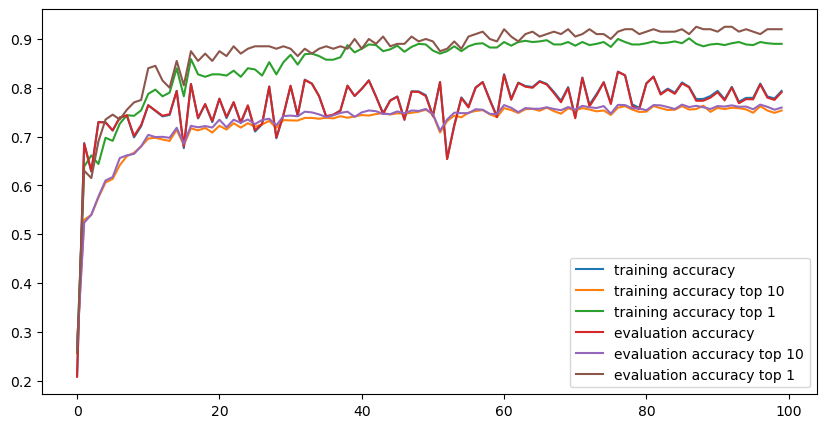

In [423]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.twinx().plot(train_loss, color="blue", label="training loss")
ax.plot(train_acc, label="training accuracy")
ax.plot(train_acc_10, label="training accuracy top 10")
ax.plot(train_acc_1, label="training accuracy top 1")
ax.plot(eval_acc, label="evaluation accuracy")
ax.plot(eval_acc_10, label="evaluation accuracy top 10")
ax.plot(eval_acc_1, label="evaluation accuracy top 1")
ax.legend()

In [428]:
with torch.no_grad():
    idx = 876
    y_pred = torch.exp(model(dataset[idx].x.cuda(), dataset[idx].edge_index.cuda()))
    y_pred_sorted, indices = y_pred.sort(dim=0, descending=True)
    # print(y_pred_sorted)
    print(dataset[idx].solution[indices[0:10, 1]])

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1])


In [430]:
# torch.save(model, "WMVC_erdos_reyni_small.pt")

# PACE 2019 Competition Graphs

In [11]:
rows = []

filepaths = list(yield_metis_filenames("../data/pace_unweighted/"))
# print(filepaths)
for filepath in tqdm(filepaths):
    path = filepath.resolve()
    # print(path)
    G = metis_to_nx(path)
    rows.append(pd.Series(summarize_graph(G, path.stem)))

    gc.collect()

df_pace = pd.DataFrame(rows).set_index("name")
df_pace

100%|██████████| 200/200 [54:53<00:00, 16.47s/it]   


,n_nodes,n_edges,avg_deg,n_components,n_isolates,sum_weights,treewidth_min_degree,average_clustering
name,,,,,,,,
vc-exact_001,6160,40207,13.054221,32,0,6160,131,0.697
vc-exact_002,51795,41253,1.592934,10542,0,51795,1,0.000
vc-exact_003,60541,48418,1.599511,12123,0,60541,1,0.000
vc-exact_004,8114,26013,6.411881,6,0,8114,1612,0.013
vc-exact_005,200,798,7.980000,1,0,200,85,0.051
...,...,...,...,...,...,...,...,...
vc-exact_196,1534,126082,164.383312,1,0,1534,1342,0.221
vc-exact_197,1534,127011,165.594524,1,0,1534,1336,0.207
vc-exact_198,1150,80072,139.255652,1,0,1150,1008,0.226


In [12]:
df_pace.to_csv("pace_unweighted.csv")

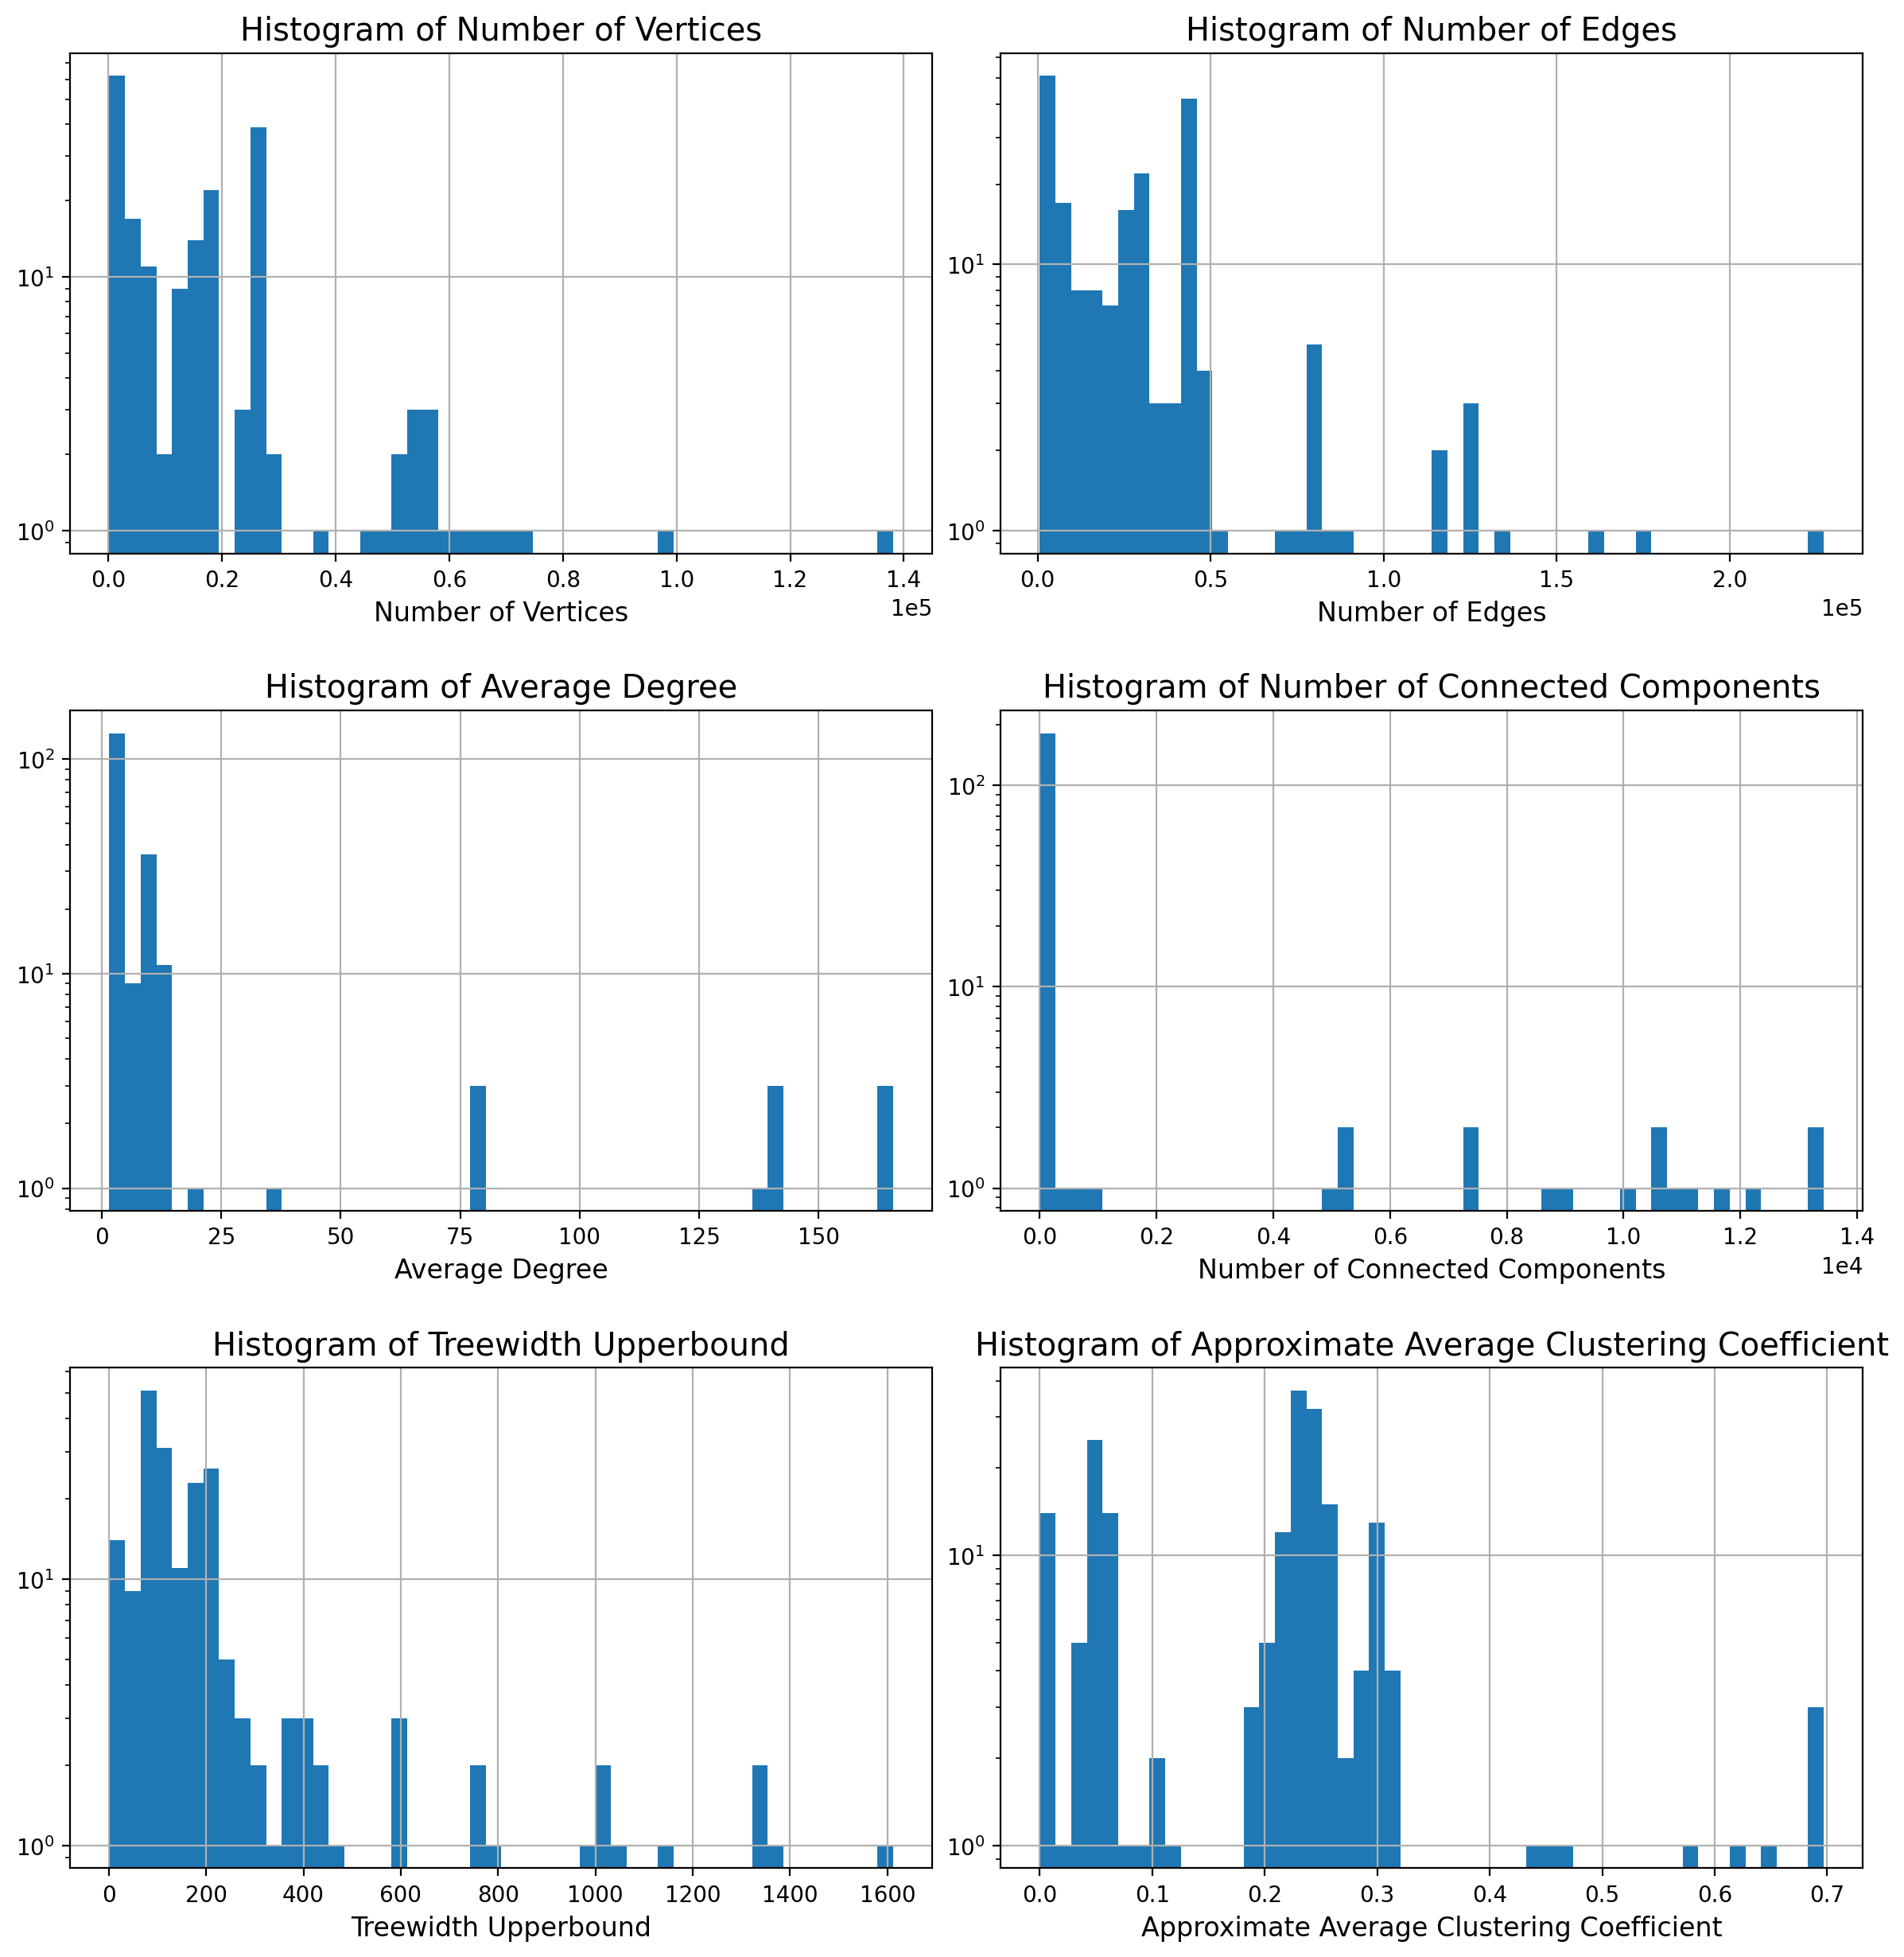

In [4]:
df_pace = pd.read_csv("pace_unweighted.csv")

plot_graph_df(df_pace)
plt.savefig("pace_unweighted.pdf", bbox_inches="tight")